In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

In [114]:
parent_directory = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))),'data')
atlas_directory = os.path.join(parent_directory,"atlas")
data_final_directory = os.path.join(parent_directory,"data_final")

assert os.path.isdir(parent_directory), f"{parent_directory} does not exist."

# read metadata csv
metadata_csv = pd.read_csv("../../data/data_final/combined_atlas_metadata.csv")

sleep_stages_to_run = ["W","N2","N3","R"]
band_names = ["delta", "theta", "alpha", "beta", "gamma", "broad"]

# load z-score npz files
bp_scores = np.load(os.path.join(data_final_directory,'combined_atlas_bandpower_normative.npz'), allow_pickle=True)
co_scores = np.load(os.path.join(data_final_directory,'combined_atlas_coherence_normative.npz'), allow_pickle=True)
#bool_dict = {np.nan: False, True: True, False: False}

In [115]:
y_train = []
# get indices of patients in metadata_csv with Engel class 1
good_outcome_indices = np.where(metadata_csv["engel"] == 1)[0]
# good outcome rows
good_outcome_rows = metadata_csv.iloc[good_outcome_indices]

>> Sleep stage: W
(2984, 5)
(2984, 10)
Fold 0:
Confusion matrix:
 [[269   0]
 [  7   0]]
Fold 1:
Confusion matrix:
 [[277   0]
 [ 33   0]]
Fold 2:
Confusion matrix:
 [[305   1]
 [  4   0]]
Fold 3:
Confusion matrix:
 [[281   1]
 [  9   0]]
Fold 4:
Confusion matrix:
 [[253   0]
 [ 22   0]]
Fold 5:
Confusion matrix:
 [[276   0]
 [  9   0]]
Fold 6:
Confusion matrix:
 [[260   4]
 [  9   1]]
Fold 7:
Confusion matrix:
 [[230   0]
 [ 44   0]]
Fold 8:
Confusion matrix:
 [[283   0]
 [  7   0]]
Fold 9:
Confusion matrix:
 [[285   1]
 [  9   0]]
Scores: [0.9746376811594203, 0.8935483870967742, 0.9838709677419355, 0.9656357388316151, 0.92, 0.968421052631579, 0.9525547445255474, 0.8394160583941606, 0.9758620689655172, 0.9661016949152542]
Mean of scores: 0.9440048394261804

Results for testing model trained on good outcome patients on patients with no surgery: (stage = W)
Score on patients with no surgery: 0.9284093253558903


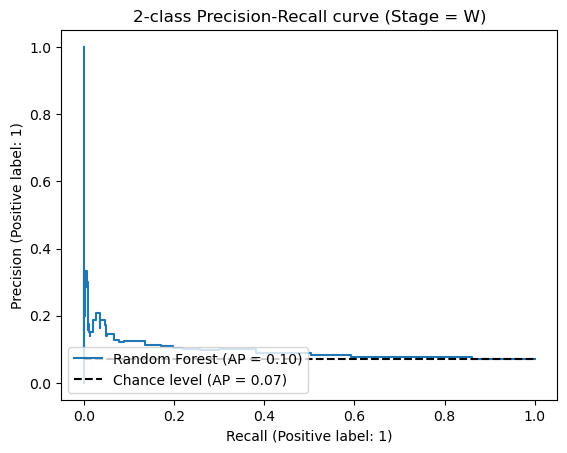

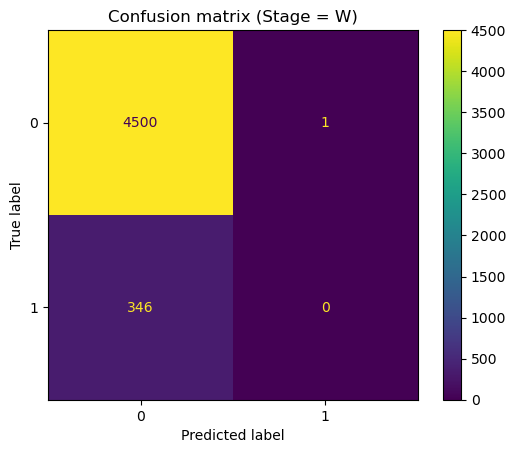

>> Sleep stage: N2
(2984, 5)
(2984, 10)
Fold 0:
Confusion matrix:
 [[241   0]
 [ 20   1]]
Fold 1:
Confusion matrix:
 [[256   0]
 [  6   0]]
Fold 2:
Confusion matrix:
 [[248   0]
 [ 13   0]]
Fold 3:
Confusion matrix:
 [[246   0]
 [  7   0]]
Fold 4:
Confusion matrix:
 [[236   1]
 [ 16   0]]
Fold 5:
Confusion matrix:
 [[237   0]
 [  4   0]]
Fold 6:
Confusion matrix:
 [[214   3]
 [ 21   1]]
Fold 7:
Confusion matrix:
 [[241   0]
 [ 21   0]]
Fold 8:
Confusion matrix:
 [[246   0]
 [ 15   0]]
Fold 9:
Confusion matrix:
 [[239   0]
 [ 16   0]]
Scores: [0.9236641221374046, 0.9770992366412213, 0.9501915708812261, 0.9723320158102767, 0.932806324110672, 0.983402489626556, 0.899581589958159, 0.9198473282442748, 0.9425287356321839, 0.9372549019607843]
Mean of scores: 0.943870831500276

Results for testing model trained on good outcome patients on patients with no surgery: (stage = N2)
Score on patients with no surgery: 0.9264640143048726


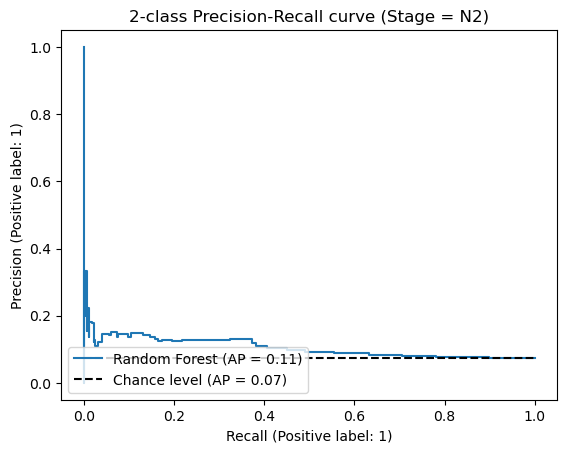

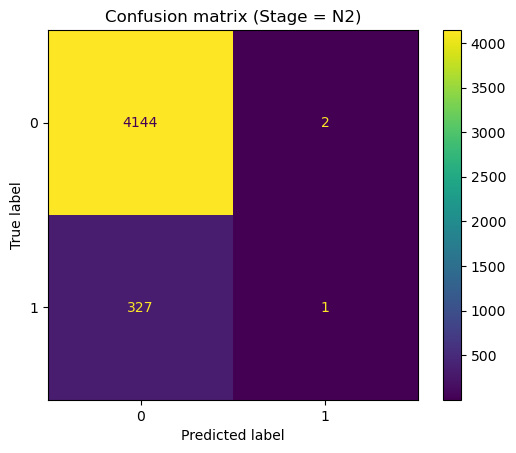

>> Sleep stage: N3
(2984, 5)
(2984, 10)
Fold 0:
Confusion matrix:
 [[233   1]
 [ 16   0]]
Fold 1:
Confusion matrix:
 [[244   1]
 [ 11   0]]
Fold 2:
Confusion matrix:
 [[244   0]
 [ 11   0]]
Fold 3:
Confusion matrix:
 [[231   1]
 [  9   0]]
Fold 4:
Confusion matrix:
 [[243   0]
 [  7   0]]
Fold 5:
Confusion matrix:
 [[211   0]
 [ 10   0]]
Fold 6:
Confusion matrix:
 [[210   0]
 [ 10   0]]
Fold 7:
Confusion matrix:
 [[253   0]
 [  3   0]]
Fold 8:
Confusion matrix:
 [[221   1]
 [ 12   0]]
Fold 9:
Confusion matrix:
 [[222   1]
 [ 30   0]]
Scores: [0.932, 0.953125, 0.9568627450980393, 0.9585062240663901, 0.972, 0.9547511312217195, 0.9545454545454546, 0.98828125, 0.9444444444444444, 0.8774703557312253]
Mean of scores: 0.9491986605107272

Results for testing model trained on good outcome patients on patients with no surgery: (stage = N3)
Score on patients with no surgery: 0.9239910313901345


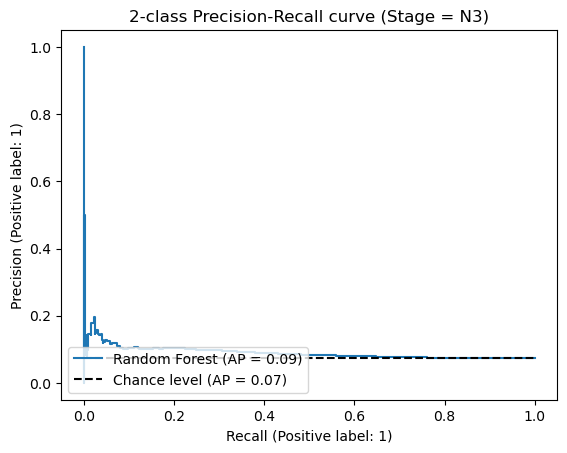

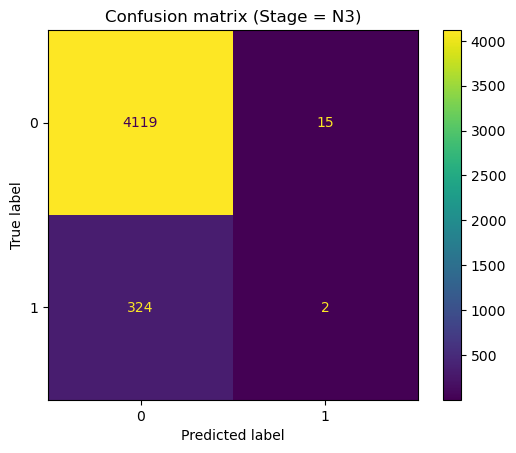

>> Sleep stage: R
(2984, 5)
(2984, 10)
Fold 0:
Confusion matrix:
 [[216   1]
 [ 19   0]]
Fold 1:
Confusion matrix:
 [[204   0]
 [ 16   0]]
Fold 2:
Confusion matrix:
 [[225   0]
 [ 10   0]]
Fold 3:
Confusion matrix:
 [[201   0]
 [  6   0]]
Fold 4:
Confusion matrix:
 [[202   1]
 [  8   0]]
Fold 5:
Confusion matrix:
 [[189   1]
 [ 19   0]]
Fold 6:
Confusion matrix:
 [[216   0]
 [  9   0]]
Fold 7:
Confusion matrix:
 [[201   0]
 [  3   0]]
Fold 8:
Confusion matrix:
 [[180   0]
 [ 29   0]]
Fold 9:
Confusion matrix:
 [[204   1]
 [  1   0]]
Scores: [0.9152542372881356, 0.9272727272727272, 0.9574468085106383, 0.9710144927536232, 0.957345971563981, 0.9043062200956937, 0.96, 0.9852941176470589, 0.861244019138756, 0.9902912621359223]
Mean of scores: 0.9429469856406536

Results for testing model trained on good outcome patients on patients with no surgery: (stage = R)
Score on patients with no surgery: 0.9135597901132284


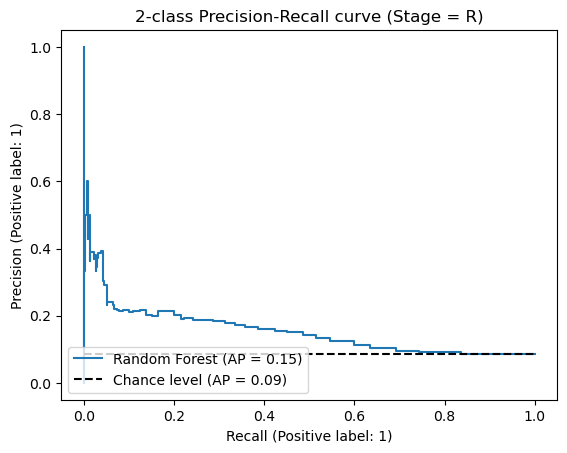

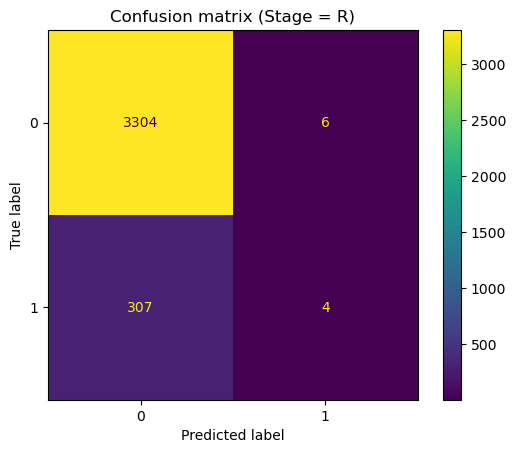

In [128]:
# for each sleep stage
for stage in sleep_stages_to_run:
    print(f">> Sleep stage: {stage}")

    this_bp_scores = bp_scores[stage]
    this_co_scores = co_scores[stage]

    X_train = []
    # get the rows of this_bp_scores for X_train
    X_train = np.array(this_bp_scores)[good_outcome_indices,:]
    print(X_train.shape)
    # get the rows of this_co_scores for X_train
    X_train = np.concatenate((X_train, np.array(this_co_scores)[good_outcome_indices,0:5]), axis=1)
    print(X_train.shape)

    groups = np.array(good_outcome_rows["pt"])

    # get rows of patients with at least one True in Ch1_resected or Ch2_resected and at least one True in Ch1_soz or Ch2_soz
    y_train = np.array([int(((row[1]["ch1_resected"] is True) | (row[1]["ch2_resected"] is True)) & ((row[1]["ch1_soz"] is True) | (row[1]["ch2_soz"] is True))) for row in good_outcome_rows.iterrows()])

    # get rows in X_train that have at least one NaN or Inf
    nan_indices = np.where(np.isnan(X_train).any(axis=1) | np.isinf(X_train).any(axis=1))[0]
    # remove rows with NaN
    X_train = np.delete(X_train, nan_indices, axis=0)
    y_train = np.delete(y_train, nan_indices)    
    groups = np.delete(groups, nan_indices)

    # 10 fold validation
    cross_val_scores = []
    group_kfold = GroupKFold(n_splits=10)
    for i, (train_index, test_index) in enumerate(group_kfold.split(X_train, y_train, groups)):
        print(f"Fold {i}:")
        #print(f"  Train: index={train_index}, group={groups[train_index]}")
        #print(f"  Test:  index={test_index}, group={groups[test_index]}")

        rf = RandomForestClassifier()
        rf.fit(X_train[train_index,:], y_train[train_index.astype(int)])
        pred = rf.predict(X_train[test_index,:])
        cm = confusion_matrix(y_train[test_index], pred)
        print(f"Confusion matrix:\n {cm}")

        cross_val_scores.append(rf.score(X_train[test_index], y_train[test_index]))

    #scores = cross_val_score(rf, X_train, y_train, cv=10, error_score="raise")
    print(f"Scores: {cross_val_scores}")
    print(f"Mean of scores: {np.mean(cross_val_scores)}")

    # test on patients with no surgery
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # get indices of patients with nan in both resected columns
    no_surg_indices = np.where(pd.isnull(metadata_csv["ch1_resected"]) & pd.isnull(metadata_csv["ch2_resected"]))[0]

    X_no_surg_train = np.array(this_bp_scores)[no_surg_indices,:]
    X_no_surg_train = np.concatenate((X_no_surg_train, np.array(this_co_scores)[no_surg_indices,0:5]), axis=1)
    # 1 if at least one True in ch1_soz or ch2_soz
    y_no_surg_train = [int((row[1]["ch1_soz"] is True) | (row[1]["ch2_soz"] is True)) for row in metadata_csv.iloc[no_surg_indices].iterrows()]

    # get rows in X_train that have at least one Inf or NaN
    nan_indices = np.where(np.isnan(X_no_surg_train).any(axis=1) | np.isinf(X_no_surg_train).any(axis=1))[0]
    # remove rows with NaN
    X_no_surg_train = np.delete(X_no_surg_train, nan_indices, axis=0)
    y_no_surg_train = np.delete(y_no_surg_train, nan_indices)

    no_surg_score = rf.score(X_no_surg_train, y_no_surg_train)

    print(f"\nResults for testing model trained on good outcome patients on patients with no surgery: (stage = {stage})")

    print(f"Score on patients with no surgery: {no_surg_score}")

    display = PrecisionRecallDisplay.from_estimator(rf, X_no_surg_train, y_no_surg_train, name="Random Forest", plot_chance_level=True)
    _ = display.ax_.set_title(f"2-class Precision-Recall curve (Stage = {stage})")

    pred = rf.predict(X_no_surg_train)
    cm = confusion_matrix(y_no_surg_train, pred)
    #print(f"Confusion matrix: {cm}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
    disp.plot()
    disp.ax_.set_title(f"Confusion matrix (Stage = {stage})")
    plt.show()